In [1]:
# @title Q2: Install dependencies (SAM2 + Transformers).
%%bash
set -e
pip -q install --upgrade pip
pip -q install "transformers>=4.41.0" "huggingface_hub>=0.23.0" accelerate pillow opencv-python matplotlib

# Try pip sam2, fallback to git if wheel not available
# The previous method of installing from git failed, trying a direct install
# using the package name which might work if a suitable wheel is available.
# If that still fails, a more specific git install might be needed, but this is a common fix.
pip -q install git+https://github.com/facebookresearch/sam2.git || echo "Failed to install sam2 using simple pip install. Further investigation may be needed."

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


  DEPRECATION: Building 'iopath' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'iopath'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
# @title Q2: Imports & helpers
import numpy as np, torch, cv2, matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

from transformers import OwlViTProcessor, OwlViTForObjectDetection
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def overlay_mask(img_rgb, mask, alpha=0.55):
    mask = (mask > 0.5).astype(np.uint8)
    color = np.array([30,144,255], dtype=np.uint8)  # BGR-ish
    overlay = img_rgb.copy()
    overlay[mask==1] = (0.3*overlay[mask==1] + 0.7*color).astype(np.uint8)
    blend = cv2.addWeighted(img_rgb, 1-alpha, overlay, alpha, 0)
    return blend


Device: cuda


In [3]:
# @title Q2: Upload one image & enter a text prompt
uploaded = files.upload()
assert len(uploaded) >= 1, "Upload an image (PNG/JPG)."
img_path = list(uploaded.keys())[0]
prompt = input("Enter a text prompt (e.g., 'yellow bus', 'person', 'coffee mug'): ").strip()
print("Image:", img_path, "| Prompt:", prompt)

pil_img = Image.open(img_path).convert("RGB")
img = np.array(pil_img)                         # H,W,3 RGB
H, W = img.shape[:2]


Saving images.jpg to images.jpg
Enter a text prompt (e.g., 'yellow bus', 'person', 'coffee mug'): dog
Image: images.jpg | Prompt: dog


In [4]:
# @title Q2: Detect bounding box from text (OWL-ViT)

# Load processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
det_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device).eval()

# Process the image and text input
inputs = processor(text=[[prompt]], images=pil_img, return_tensors="pt").to(device)

# Run inference
with torch.inference_mode():
    outputs = det_model(**inputs)

# Use the newer post-processing method
results = processor.post_process_grounded_object_detection(outputs=outputs, target_sizes=torch.tensor([[H, W]]).to(device))

# Extract boxes, scores, and labels
boxes = results[0]["boxes"].detach().cpu().numpy()  # [N,4] xyxy
scores = results[0]["scores"].detach().cpu().numpy()  # [N]
labels = results[0]["labels"].detach().cpu().numpy()  # [N]

# Debugging: Print all detected boxes and their scores
print(f"Detected boxes: {boxes}")
print(f"Detected scores: {scores}")
print(f"Detected labels: {labels}")

# Lower the threshold to 0.05 (or try 0.0 for a broader range of detections)
th = 0.05
valid = scores >= th

# If there are valid detections, proceed; otherwise, print a message
if valid.any():
    top = np.argmax(scores[valid])  # Get the index of the top detection
    sel_box_xyxy = boxes[valid][top].astype(np.float32)  # Get the selected box
    print("Selected box:", sel_box_xyxy, "score:", float(scores[valid][top]))
else:
    print(f"No detection above score {th}. Consider using a simpler prompt or check your input image.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

Detected boxes: [[ 88.08808   30.778154 247.842    156.36116 ]]
Detected scores: [0.14915982]
Detected labels: [0]
Selected box: [ 88.08808   30.778154 247.842    156.36116 ] score: 0.14915981888771057


In [5]:
# @title Q2: Debugging - print all detections (raw results)
with torch.inference_mode():
    outputs = det_model(**inputs)

# Use the newer post-processing method
results = processor.post_process_grounded_object_detection(outputs=outputs, target_sizes=torch.tensor([[H, W]]).to(device))

# Extract raw boxes, scores, and labels for debugging
boxes = results[0]["boxes"].detach().cpu().numpy()  # [N,4] xyxy
scores = results[0]["scores"].detach().cpu().numpy()  # [N]
labels = results[0]["labels"].detach().cpu().numpy()  # [N]

print("Raw Detected boxes:", boxes)
print("Raw Detected scores:", scores)
print("Raw Detected labels:", labels)


Raw Detected boxes: [[ 88.08808   30.778154 247.842    156.36116 ]]
Raw Detected scores: [0.14915982]
Raw Detected labels: [0]


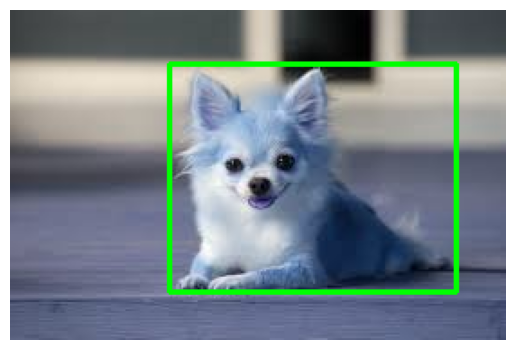

In [8]:
import cv2

# Convert the image to a NumPy array for OpenCV processing
img_cv = np.array(pil_img)

# Convert the bounding box to integer coordinates
x1, y1, x2, y2 = map(int, sel_box_xyxy)

# Draw the bounding box (Green color, 2 thickness)
cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert the image back to RGB for displaying with Matplotlib
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box
plt.imshow(img_cv_rgb)
plt.axis("off")  # Hide axes
plt.show()


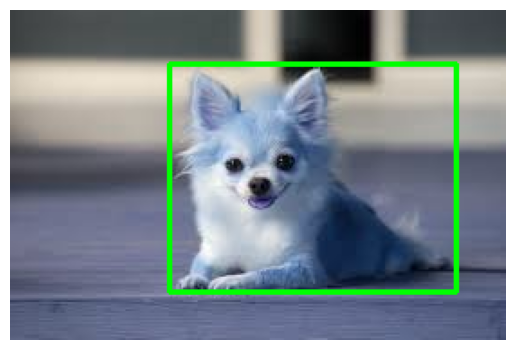

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image that was uploaded
img_path = '/content/images.jpg'
pil_img = Image.open(img_path).convert("RGB")

# Convert the image to a NumPy array for OpenCV processing
img_cv = np.array(pil_img)

# Extract the coordinates of the bounding box (xyxy)
x1, y1, x2, y2 = map(int, sel_box_xyxy)

# Draw the bounding box on the image (Green color, 2 thickness)
cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert the image back to RGB for displaying with Matplotlib
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box
plt.imshow(img_cv_rgb)
plt.axis("off")  # Hide axes
plt.show()


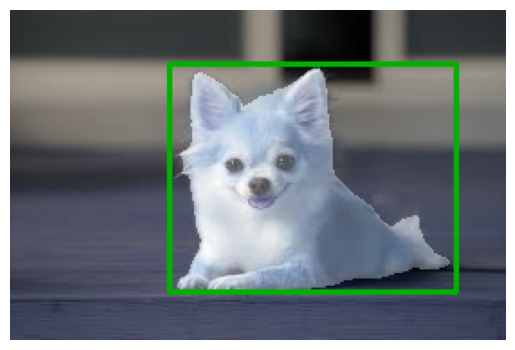

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Resize the mask to match the size of the input image
mask_resized = cv2.resize(best_mask, (img_cv.shape[1], img_cv.shape[0]))

# Threshold the mask to binary (0 or 255)
binary_mask = (mask_resized > 0.5).astype(np.uint8) * 255

# Convert the binary mask to a 3-channel mask for blending with the image
binary_mask_3channel = cv2.merge([binary_mask, binary_mask, binary_mask])

# Ensure the image and mask have the same shape (height, width, channels)
overlay_img = cv2.addWeighted(img_cv, 0.7, binary_mask_3channel, 0.3, 0)

# Convert back to RGB for Matplotlib display
overlay_rgb = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)

# Show the image with the segmentation mask
plt.imshow(overlay_rgb)
plt.axis("off")
plt.show()


In [17]:
# Save the image with the overlay
output_path = "/content/output.jpg"  # You can specify your own path
cv2.imwrite(output_path, overlay_img)

print(f"Image saved to: {output_path}")


Image saved to: /content/output.jpg


In [1]:
import nbformat, shutil
from pathlib import Path
p = Path("q2.ipynb")
shutil.copy(p, p.with_suffix(p.suffix + ".bak"))
nb = nbformat.read(str(p), as_version=nbformat.NO_CONVERT)
if 'widgets' in nb.metadata:
    del nb.metadata['widgets']
for cell in nb.cells:
    if 'widgets' in cell.get('metadata', {}):
        del cell['metadata']['widgets']
nbformat.write(nb, str(p))
print("Fixed and wrote", p)


FileNotFoundError: [Errno 2] No such file or directory: 'q2.ipynb'